In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 9.3 MB/s 


In [3]:
pip install patool

     |████████████████████████████████| 77 kB 4.5 MB/s 


In [4]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/train_subset.rar", outdir="/content/sample_data")

patool: Extracting /content/drive/MyDrive/train_subset.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/train_subset.rar
patool:     with cwd='/content/sample_data'
patool: ... /content/drive/MyDrive/train_subset.rar extracted to `/content/sample_data'.


'/content/sample_data'

In [5]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

In [6]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import glob

In [7]:
lables = os.listdir('/content/sample_data/train_set')

In [8]:
l =[] 
for x in lables:
  y = x.lstrip('0')
  if y == '':
    l.append(0)
  else:  
    l.append(int(y))


In [9]:
train_label = pd.read_csv('/content/train_labels.csv')



In [10]:
target_train = []
for x in l:
  target_train.append(train_label[train_label['BraTS21ID']==x]['MGMT_value'])

In [11]:
target_train = np.array(target_train)

In [12]:
tain_set_org_path = '/content/sample_data/train_set'
l = os.listdir(tain_set_org_path)
path5=[]
for x in l:
  path1 = os.path.join(tain_set_org_path,x)
  path2 = os.listdir(path1)
  for z in path2:
    path3 = os.path.join(path1,z)
    path4 = os.listdir(path3)
    for y in path4:
      path5.append(os.path.join(path3,y))




In [13]:
NUM_IMAGES_3D = 64
TRAINING_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
IMAGE_SIZE = 64
N_EPOCHS = 15
do_valid = True
n_workers = 4


In [14]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    if rotate > 0:
        rot_choices = [
            0,
            cv2.ROTATE_90_CLOCKWISE,
            cv2.ROTATE_90_COUNTERCLOCKWISE,
            cv2.ROTATE_180,
        ]
        data = cv2.rotate(data, rot_choices[rotate])

    data = cv2.resize(data, (img_size, img_size))
    return data

In [15]:
from google.colab.patches import cv2_imshow
def subset_of_data_set(path5):
  data = []
  for x in path5:
    num_imgs = NUM_IMAGES_3D
    img_size=IMAGE_SIZE
    out = [load_dicom_image(x)]
    img3d = np.stack(out).T
    if img3d.shape[-1] < num_imgs:
      n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
      img3d = np.concatenate((img3d, n_zero), axis=-1)
    if np.min(img3d) < np.max(img3d):
      img3d = img3d - np.min(img3d)
      img3d = img3d / np.max(img3d)
    data.append(out)    
  return np.array(data)



In [16]:
def subset_of_data_set1(path5):
  data = []
  for x in path5:
    out = [load_dicom_image(x)]
    data.append(out)    
  return np.array(data)

In [17]:
data = subset_of_data_set1(path5[0:-1:5])

In [18]:
data.shape

(3895, 1, 64, 64)

In [19]:
data1 = data.reshape(data.shape[0],data.shape[-1],data.shape[-2],1)

In [20]:
y1 =[]
for i  in range(len(path5[0:-1:5])):
  y = path5[i].split('/')[-3].lstrip('0')
  if y == '':
    y1.append(0)
  else:  
    y1.append(int(y))



In [21]:
target_train1 = []
for x in y1:
  target_train1.append(train_label[train_label['BraTS21ID']==x]['MGMT_value'].values)

In [22]:
target_train2 = np.array(target_train1)

In [23]:
one_hot_r=pd.get_dummies(target_train2.ravel(), prefix_sep='_', drop_first=False)
target1=np.array(one_hot_r)
target1.shape

(3895, 2)

In [55]:
from sklearn.model_selection import train_test_split
train_set, test_set,target_train,target_test = train_test_split(data1, target1, test_size=0.3,random_state=0)

In [25]:
print(target_train.shape,target_test.shape)
print(test_set.shape)
print(train_set.shape)

(2726, 2) (1169, 2)
(1169, 64, 64, 1)
(2726, 64, 64, 1)


In [26]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=9fe3f4e0681bca43435184936ad1cc84b8fa7810add29e4783dfab63195f4a6e
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet


In [27]:
import keras
import keras_resnet.models
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras import Model

In [28]:
shape, classes = (train_set.shape[1], train_set.shape[2], 1), 2
input = Input(shape=(train_set.shape[1], train_set.shape[2], 1))
model = keras_resnet.models.ResNet50(input, classes=classes)
last_layer = model.get_layer('pool5').output
last_layer1 = Dropout(0.40)(last_layer)
x= Flatten(name='flatten')(last_layer1)
x = Dropout(0.40)(x)
out = Dense(2, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=input,outputs= out)

custom_resnet_model.compile("adam", "binary_crossentropy", ["accuracy"])
hist = custom_resnet_model.fit(train_set, target_train, batch_size=512,validation_batch_size=512,epochs=40, verbose=1, validation_split=0.2)
custom_resnet_model.save("ResNet.h5")

Epoch 1/40
5/5 [==============================] - 266s 50s/step - loss: 1.1614 - accuracy: 0.6752 - val_loss: 296370.3125 - val_accuracy: 0.7289
Epoch 2/40
5/5 [==============================] - 259s 50s/step - loss: 0.8626 - accuracy: 0.6913 - val_loss: 3498973.2500 - val_accuracy: 0.7289
Epoch 3/40
5/5 [==============================] - 258s 50s/step - loss: 0.7328 - accuracy: 0.7156 - val_loss: 3220733.2500 - val_accuracy: 0.7289
Epoch 4/40
5/5 [==============================] - 255s 49s/step - loss: 0.7532 - accuracy: 0.7023 - val_loss: 2898460.0000 - val_accuracy: 0.7289
Epoch 5/40
5/5 [==============================] - 260s 50s/step - loss: 0.6882 - accuracy: 0.7252 - val_loss: 1086927.8750 - val_accuracy: 0.7289
Epoch 6/40
5/5 [==============================] - 260s 50s/step - loss: 0.6073 - accuracy: 0.7431 - val_loss: 80694.4219 - val_accuracy: 0.7289
Epoch 7/40
5/5 [==============================] - 268s 52s/step - loss: 0.5948 - accuracy: 0.7729 - val_loss: 96143.7656 - val_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [38]:
!cp /content/ResNet.h5 /content/drive/MyDrive 

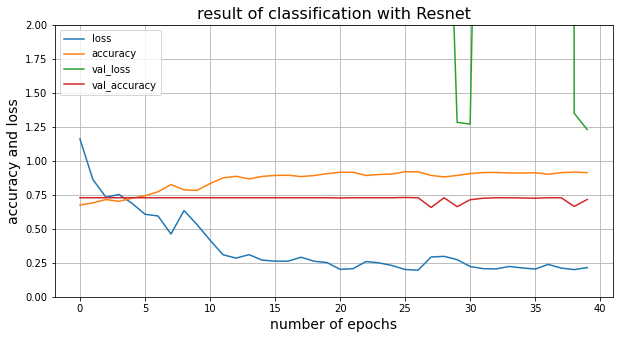

In [29]:
import pandas as pd
pd.DataFrame(hist.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.xlabel('number of epochs', fontsize=14)
plt.ylabel('accuracy and loss', fontsize=14)
plt.title('result of classification with Resnet',fontsize=16)
plt.show()

In [30]:
custom_resnet_model.evaluate(test_set,target_test)

37/37 [==============================] - 12s 335ms/step - loss: 1.3236 - accuracy: 0.7117


[1.3235979080200195, 0.7117193937301636]

In [56]:
pred = custom_resnet_model.predict(test_set)

In [57]:
predd = custom_resnet_model.predict(train_set)

In [63]:
pred_total = pd.concat([pd.DataFrame(predd),pd.DataFrame(pred)])
pred_total = np.array(pred_total)

In [64]:
pred_total1=[]
for x in pred_total:
  pred_total1.append(max(x))


In [ ]:
pd.DataFrame(pred_total).value_counts()

In [65]:
pred_total1 = pd.DataFrame(pred_total1)

In [66]:
train_label['pred_total'] = pred_total1

In [67]:
train_label

,BraTS21ID,MGMT_value,pred_total
0,0,1,0.936618
1,2,1,0.999629
2,3,0,0.994622
3,5,1,0.999758
4,6,1,0.995319
...,...,...,...
580,1005,1,0.999999
581,1007,1,0.946241
582,1008,1,1.000000
583,1009,0,0.999999


In [33]:
pd.DataFrame(target_test).value_counts()

0  1
0  1    832
1  0    337
dtype: int64

In [50]:
pred1=[]
for x in pred:
  pred1.append(max(x))

<BarContainer object of 1169 artists>

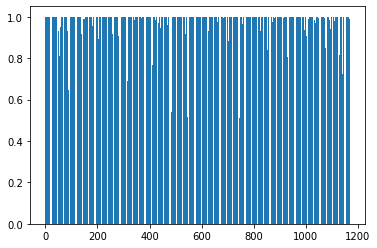

In [54]:
plt.bar(range(len(pred1)) ,pred1)

In [53]:
pd.DataFrame(pred).value_counts()

0             1       
1.536546e-06  0.999998    110
1.536544e-06  0.999998      6
1.808923e-01  0.819108      5
3.099109e-06  0.999997      2
6.896269e-02  0.931037      2
                         ... 
1.246510e-03  0.998753      1
1.208978e-03  0.998791      1
1.151679e-03  0.998848      1
1.098841e-03  0.998901      1
3.358094e-35  1.000000      1
Length: 1046, dtype: int64

In [35]:
out = []
for x in pred:
  out.append(np.argmax(x))
out = np.array(out)

In [42]:
pd.DataFrame(out).value_counts()

1    832
0    337
dtype: int64

<BarContainer object of 2 artists>

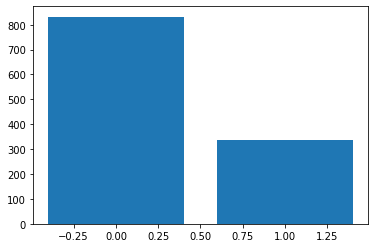

In [48]:
plt.bar(np.arange(0,2) ,pd.DataFrame(out).value_counts())